In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mne

import warnings
warnings.filterwarnings('ignore')

from pingouin import ttest

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [2]:
# Functions

def data_norm(data):
    return (data - data.min())/ (data.max() - data.min())

def get_sorted_vals(df, channels, feature='', avg_type='median'):
    """gets values of specparam feature sorted by channels in MNE object
    
    Parameters
    ----------
    df: dataframe
        dataframe of all subjects & specparam features
    channels: list
        channels in MNE object in order, will be used to determine final order of values
    feature: str
        feature of interest, must match column in df
    avg_type: str
        method to get value of avg feature for each electrode across subject, mean or median
        
    Returns
    -------
    sorted_pre_features: 1d array
        values of desired parameter pre-treatment in the same order as MNE channels
    sorted_post_features: 1d array
        same but post
    sorted_diff_features: 1d array
        same but diff
    t_vals: 1d array
        t-statistics of desired parameter per chanel, pre- vs. post from paired ttest
        """
    # get difference dataframe
    diff_array = pd.DataFrame(df.groupby(['patient','channel'], as_index=False)[feature].diff())
    diff_array[['patient','channel', 'pre_post']] = df[['patient','channel', 'pre_post']]
    diff_array_nonan = diff_array[diff_array['pre_post']=='post']
    
    # get t-value of pre-post difference
    t_vals = []
    p_vals = []

    if feature =='delta_amp' or feature=='theta_amp' or feature=='r_squared':
        t_vals = np.nan
    else:
        for chan in channels:
            pre_vals = df[(df['channel']==chan) &
                                       (df['pre_post']=='pre')][feature].values
            post_vals = df[(df['channel']==chan) &
                                        (df['pre_post']=='post')][feature].values

        
            stats = ttest(pre_vals, post_vals, paired=True)
            t_vals.append(float(stats['T'].values))
            p_vals.append(float(stats['p-val'].values))
  
    
    # get values from dataframe
    if avg_type == 'mean':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], as_index=False)[feature].mean())
        diff_features = pd.DataFrame(diff_array_nonan.groupby(['channel'], as_index=False)[feature].mean())
    elif avg_type == 'median':
        feature_array = pd.DataFrame(df.groupby(['pre_post', 'channel'], as_index=False)[feature].median())
        diff_features = pd.DataFrame(diff_array_nonan.groupby(['channel'], as_index=False)[feature].median())
    else:
        raise ValueError('avg_type must be mean or median')

    pre_features = feature_array[feature_array['pre_post']=='pre'][feature].values
    post_features = feature_array[feature_array['pre_post']=='post'][feature].values
    diff_features = diff_features[feature].values

    # get channels from dataframe and re-order to match MNE info object
    df_channels = list(feature_array[feature_array['pre_post']=='pre']['channel'].values)
    sorted_index = []

    for chan in df_channels:
        sorted_index.append(channels.index(chan))

    sorted_pre_features = np.array([pre_features[i] for i in sorted_index])
    sorted_post_features = np.array([post_features[i] for i in sorted_index])
    sorted_diff_features = np.array([diff_features[i] for i in sorted_index])
    
    return sorted_pre_features, sorted_post_features, sorted_diff_features, np.asarray(t_vals), np.asarray(p_vals)

In [3]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

exp_df_included = exp_df#[exp_df['exclude']==False]

In [4]:
# counts of excluded electrodes
exp_df_included.groupby(['patient', 'pre_post'])['exclude'].sum()

patient  pre_post
9        post         0
         pre          0
10       post         4
         pre          4
18       post         0
         pre          0
22       post         0
         pre          0
25       post         1
         pre          1
33       post         0
         pre          0
35       post         0
         pre          0
40       post        47
         pre         47
46       post         0
         pre          0
47       post         0
         pre          0
53       post         0
         pre          0
66       post         0
         pre          0
69       post         0
         pre          0
95       post         0
         pre          0
117      post         0
         pre          0
119      post         0
         pre          0
125      post         4
         pre          4
126      post         0
         pre          0
130      post         0
         pre          0
134      post         0
         pre          0
144      post         

### Get MNE info object for electrode positions

In [5]:
eeg_data_path = '/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif'

eeg_data = mne.io.read_raw(eeg_data_path)

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif...
    Range : 0 ... 649199 =      0.000 ...   649.199 secs
Ready.


In [6]:
eeg_data = eeg_data.pick_types(eeg=True)

In [7]:
mne_chans = eeg_data.info['ch_names']

# R$^{2}$

get topology of model fits -- are there any electrodes that are particularly bad across subjects that should be dropped across the whole dataset?

In [8]:
sorted_pre_r2s, sorted_post_r2s, diff, t_vals, _ = get_sorted_vals(exp_df_included, mne_chans, feature='r_squared', avg_type='mean')
#diff = sorted_post_r2s - sorted_pre_r2s

Text(0.5, 1.0, 'post model fit R$^{2}$')

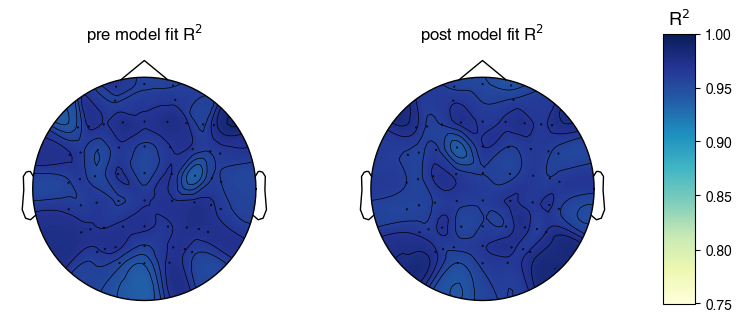

In [9]:
unit_label = 'R$^{2}$'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_r2s, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.75, vmax=1.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_r2s, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.75, vmax=1.0, cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre model fit R$^{2}$')
ax2.set_title('post model fit R$^{2}$')

# plot R2 across all subjects

average model fit plots aren't really working for me... let's see if there are consistently bad electrodes by plotting all subjects topoplots

Text(0.5, 1.0, 'R$^{2}$')

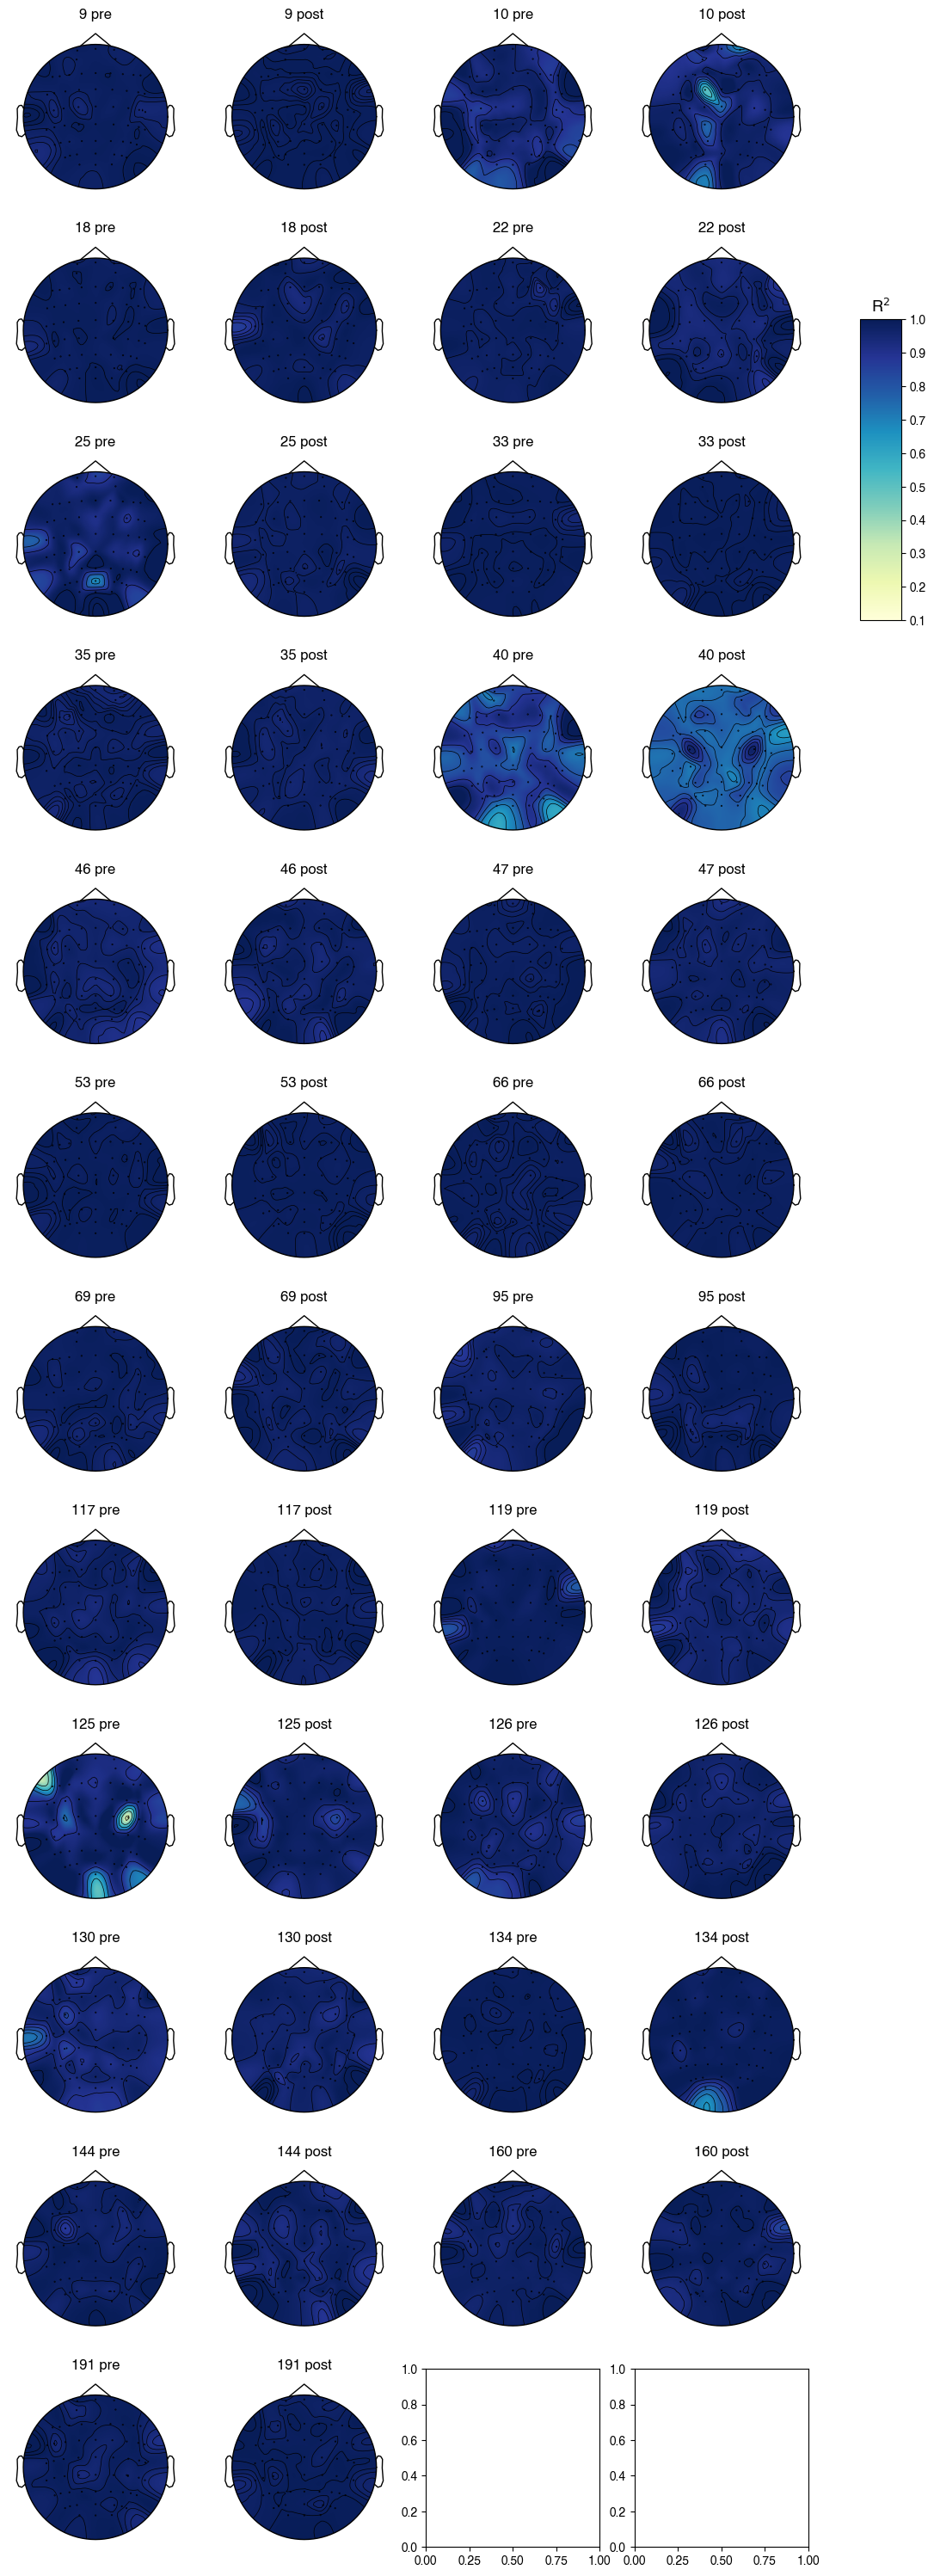

In [10]:
unit_label = 'R$^{2}$'

patients = exp_df_included['patient'].unique()

fig,axs = plt.subplots(12,4, figsize=[12,35])
axs = axs.ravel()

ind = 0

for patient in patients:
    df = exp_df_included[exp_df_included['patient']==patient]
    
    sorted_pre_r2s, sorted_post_r2s, diff, t_vals, _ = get_sorted_vals(df, mne_chans, feature='r_squared',
                                                      avg_type='mean')
    
    im, cm = mne.viz.plot_topomap(sorted_pre_r2s, axes=axs[ind], pos=eeg_data.info, show=False,
                              vmin=0.1, vmax=1.0, cmap='YlGnBu')
    axs[ind].set_title(str(patient)+' pre')
    ind +=1 
    
    im, cm = mne.viz.plot_topomap(sorted_post_r2s, axes=axs[ind], pos=eeg_data.info, show=False,
                              vmin=0.1, vmax=1.0, cmap='YlGnBu')
    axs[ind].set_title(str(patient)+' post')
    ind +=1

ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.75
ax_y_height = 0.1
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13)

# Delta

In [11]:
sorted_pre_delta_amps, sorted_post_delta_amps, diff, t_vals, _ = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='delta_amp', avg_type='median')
    
sorted_pre_delta_amps = np.nan_to_num(sorted_pre_delta_amps, nan=0.05) # replace no delta peak channels with absolute threshold
sorted_post_delta_amps = np.nan_to_num(sorted_post_delta_amps, nan=0.05) # replace no delta peak channels with abs threshold
diff = np.nan_to_num(diff, nan=0.05)

#diff = sorted_post_delta_amps - sorted_pre_delta_amps


Text(0.5, 1.0, 'post delta peak amplitude')

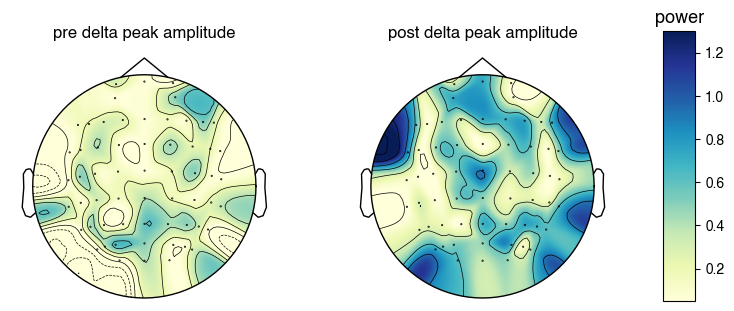

In [12]:
unit_label = 'power'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_delta_amps, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_delta_amps, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.3, cmap='YlGnBu')


# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre delta peak amplitude')
ax2.set_title('post delta peak amplitude')

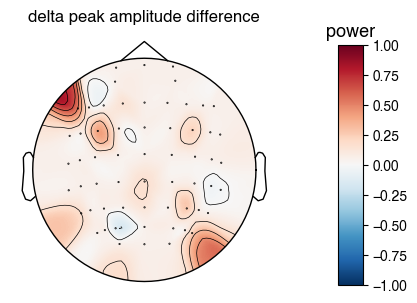

In [13]:
unit_label = 'power'
fig, ax = plt.subplots(1,1, figsize=[5,3])

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0)

# manually fiddle the position of colorbar
ax_x_start = 0.9
ax_x_width = 0.05
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar
ax.set_title('delta peak amplitude difference');

# Theta

In [57]:
sorted_pre_theta_amps, sorted_post_theta_amps, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='theta_amp', avg_type='median')
    
sorted_pre_theta_amps = np.nan_to_num(sorted_pre_theta_amps, nan=0.05) # replace no theta peak channels with absolute threshold
sorted_post_theta_amps = np.nan_to_num(sorted_post_theta_amps, nan=0.05) # replace no theta peak channels with abs threshold
diff = np.nan_to_num(diff, nan=0.05)                                                                

Text(0.5, 1.0, 'post theta peak amplitude')

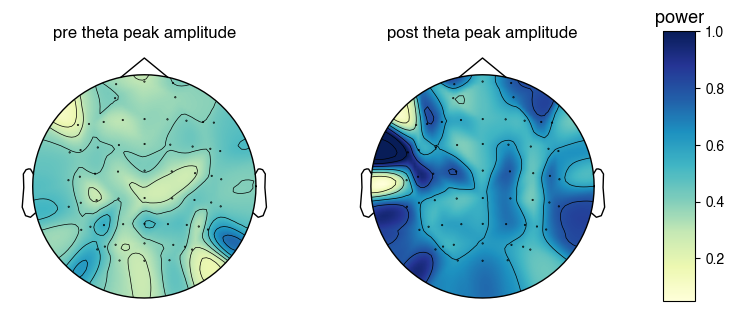

In [58]:
unit_label = 'power'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_theta_amps, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_theta_amps, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=1.0, cmap='YlGnBu')


# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre theta peak amplitude')
ax2.set_title('post theta peak amplitude')

Text(0.5, 1.0, '$\\Delta$ theta osc. power')

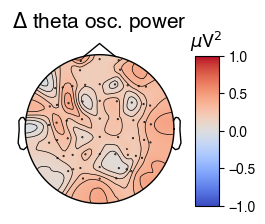

In [59]:
unit_label = '$\mu$V$^2$'
fig, ax = plt.subplots(1,1, figsize=[4,2])

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm')

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ theta osc. power', fontsize=15)

# Alpha 

In [60]:
sorted_pre_alpha_amps, sorted_post_alpha_amps, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                                feature='alpha_amp', avg_type='median')
    
sorted_pre_alpha_amps = np.nan_to_num(sorted_pre_alpha_amps, nan=0.05) # replace no alpha peak channels with absolute threshold
sorted_post_alpha_amps = np.nan_to_num(sorted_post_alpha_amps, nan=0.05) # replace no alpha peak channels with abs threshold
diff = np.nan_to_num(diff, nan=0.05)                                                                

Text(0.5, 1.0, 'post alpha peak amplitude')

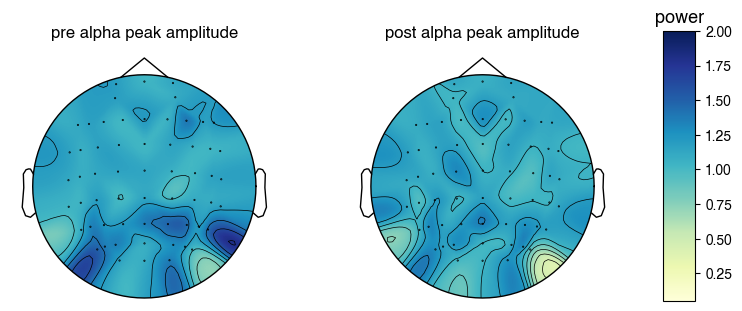

In [61]:
unit_label = 'power'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_alpha_amps, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=2.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_alpha_amps, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.05, vmax=2.0, cmap='YlGnBu')


# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre alpha peak amplitude')
ax2.set_title('post alpha peak amplitude')

Text(0.5, 1.0, '$\\Delta$ alpha osc. power')

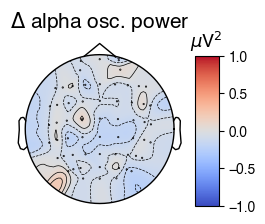

In [62]:
unit_label = '$\mu$V$^2$'
fig, ax = plt.subplots(1,1, figsize=[4,2])

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm')

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ alpha osc. power', fontsize=15)

# Exponent

In [17]:
sorted_pre_exponents, sorted_post_exponents, diff, t_vals, p_vals = get_sorted_vals(exp_df_included, mne_chans,
                                                              feature='exponent', avg_type='median')
#diff = sorted_post_exponents - sorted_pre_exponents

Text(0.5, 1.0, 'post exponent')

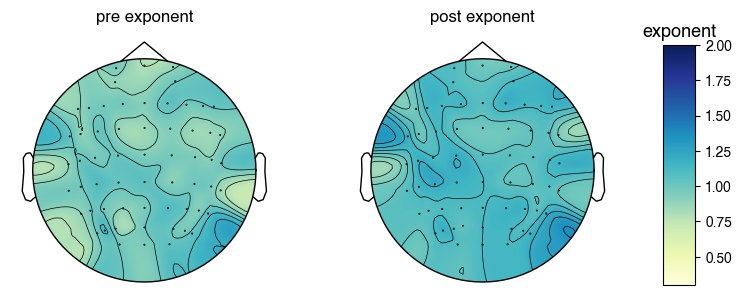

In [18]:
unit_label = 'exponent'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(sorted_pre_exponents, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0.3, vmax=2.0, cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(sorted_post_exponents, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0.3, vmax=2.0, cmap='YlGnBu')


# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.8
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre exponent')
ax2.set_title('post exponent')

In [19]:
p_vals

array([0.02032088, 0.00538374, 0.01454185, 0.0235966 , 0.11740799,
       0.00262668, 0.05079982, 0.01557489, 0.0007986 , 0.00021084,
       0.00122532, 0.00291183, 0.00958729, 0.02123316, 0.01655813,
       0.01420072, 0.00332865, 0.00362267, 0.00132333, 0.00210236,
       0.02696521, 0.0028795 , 0.00412337, 0.01309657, 0.01456761,
       0.04645015, 0.06311449, 0.01128361, 0.00303571, 0.00471889,
       0.00212014, 0.03268338, 0.02927994, 0.00357188, 0.01715913,
       0.00448732, 0.01916254, 0.00524396, 0.00362728, 0.00528927,
       0.06908877, 0.00186335, 0.00584946, 0.0085552 , 0.00621924,
       0.01444782, 0.00949984, 0.00418652, 0.00238613, 0.00195356,
       0.00501456, 0.00345246, 0.00982312, 0.0083066 , 0.00718713,
       0.00432658, 0.01256221, 0.00829178, 0.00769147, 0.00798085])

Text(0.5, 1.0, '$\\Delta$ exponent')

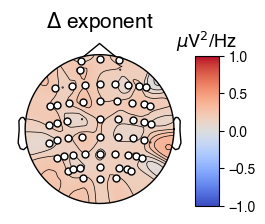

In [20]:
unit_label = '$\mu$V$^2$/Hz'
fig, ax = plt.subplots(1,1, figsize=[4,2])

mask = p_vals < 0.05
mask_params = dict(markersize=5, markerfacecolor="white")

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.0, vmax=1.0, cmap='coolwarm', mask=mask, mask_params=mask_params)

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ exponent', fontsize=15)

Text(0.5, 1.0, '$\\Delta$ exponent')

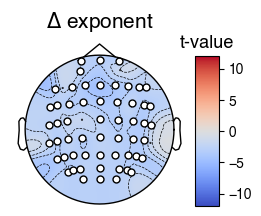

In [21]:
unit_label = 't-value'
fig, ax = plt.subplots(1,1, figsize=[4,2])

mask = p_vals < 0.05
mask_params = dict(markersize=5, markerfacecolor="white")

im, cm = mne.viz.plot_topomap(t_vals, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-12.0, vmax=12.0, cmap='coolwarm', mask=mask, mask_params=mask_params)

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ exponent', fontsize=15)

# Delta Band Power

In [22]:
sorted_pre_delta_bp, sorted_post_delta_bp, diff, t_vals, p_vals  = get_sorted_vals(exp_df_included, mne_chans,
                                                             feature='delta_bp', avg_type='median')

#diff = sorted_post_delta_bp - sorted_pre_delta_bp

In [23]:
# normalize band powers
all_bp = np.concatenate([sorted_pre_delta_bp, sorted_post_delta_bp])
norm_all = data_norm(all_bp)
norm_pre = norm_all[:60]
norm_post = norm_all[60:]


Text(0.5, 1.0, 'post delta_bp')

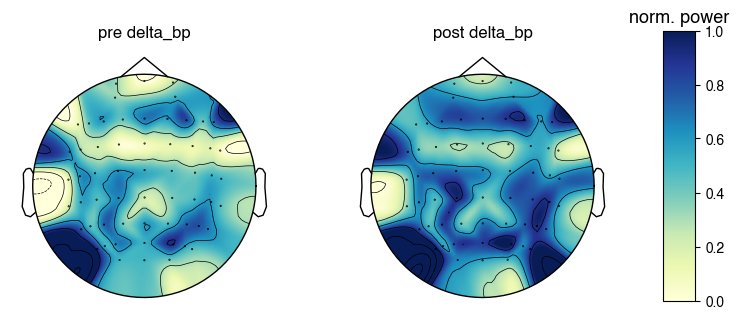

In [24]:
unit_label = 'norm. power'
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=[8,3])
im, cm = mne.viz.plot_topomap(norm_pre, axes=ax1, pos=eeg_data.info, show=False,
                              vmin=0., vmax=1., cmap='YlGnBu')
im, cm = mne.viz.plot_topomap(norm_post, axes=ax2, pos=eeg_data.info, show=False,
                              vmin=0., vmax=1., cmap='YlGnBu')

# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax1.set_title('pre delta_bp')
ax2.set_title('post delta_bp')

Text(0.5, 1.0, '$\\Delta$ band power')

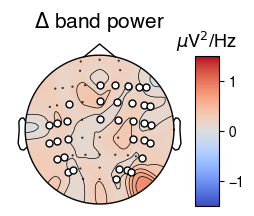

In [25]:
unit_label = '$\mu$V$^2$/Hz'

fig, ax = plt.subplots(1,1, figsize=[4,2])

mask = p_vals < 0.05
mask_params = dict(markersize=5, markerfacecolor="white")

im, cm = mne.viz.plot_topomap(diff, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-1.5, vmax=1.5, cmap='coolwarm', mask=mask, mask_params=mask_params)

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('$\Delta$ band power', fontsize=15)

Text(0.5, 1.0, 'delta band power difference')

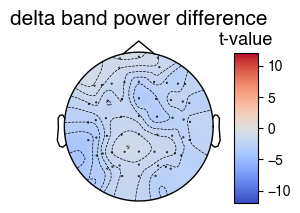

In [26]:
unit_label = 't-value'
fig, ax = plt.subplots(1,1, figsize=[4,2])

im, cm = mne.viz.plot_topomap(t_vals, axes=ax, pos=eeg_data.info, show=False,
                              vmin=-12.0, vmax=12.0, cmap='coolwarm')

# manually fiddle the position of colorbar
ax_x_start = 0.75
ax_x_width = 0.06
ax_y_start = 0.1
ax_y_height = 0.75
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title(unit_label,fontsize=13) # title on top of colorbar

ax.set_title('delta band power difference', fontsize=15)